In [2]:
import torch
import random
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchinfo import summary
from torch.utils.data import Subset
from sklearn.metrics import classification_report, f1_score, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler

### Loading Data

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
data = np.load("/kaggle/input/dataset3/denoised_eeg_data.npz") 
# data = np.load('/content/drive/My Drive/Colab Notebooks/processed_eeg_data1.npz')
# data = np.load("D:\Vanessa\Documents\eeg_data\denoised_eeg_data.npz")
X_train = data['X_train']
X_val = data['X_val']
y_train = data['y_train']
y_val = data['y_val']

In [4]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

X_train shape: (8238, 15, 23, 256)
X_val shape: (1418, 15, 23, 256)
y_train shape: (8238,)
y_val shape: (1418,)


In [18]:
print(f"Train seizure %: {100*y_train.mean():.2f}%") 
print(f"Val seizure %: {100*y_val.mean():.2f}%")

Train seizure %: 17.06%
Val seizure %: 17.63%


In [34]:
print("Train seizure:", np.mean(y_train))
print("Val seizure:", np.mean(y_val))
print("Train mean:", X_train.mean())
print("Val mean:", X_val.mean())
print("Train std:", X_train.std())
print("Val std:", X_val.std())
print("Train per-channel mean:", X_train.mean(axis=(0,2)))
print("Val per-channel mean:", X_val.mean(axis=(0,2)))

Train seizure: 0.17141377524598653
Val seizure: 0.17184265010351968
Train mean: 5.71551788123963e-05
Val mean: 0.00039751955397783863
Train std: 0.974691620259811
Val std: 0.9680529375498222
Train per-channel mean: [[-8.89703915e-04 -9.10624565e-04 -1.16107478e-03 ...  6.98804849e-04
   6.58927243e-04  4.22053556e-04]
 [-9.99562889e-06 -3.05589539e-04 -6.72089000e-04 ...  9.52487888e-06
   1.63720181e-04 -2.23897001e-04]
 [ 2.36218846e-05 -2.50274986e-04 -5.25605550e-04 ...  2.06967333e-03
   1.81577938e-03  1.18093944e-03]
 ...
 [-1.24473204e-03 -1.44045208e-03 -1.65079451e-03 ...  3.52607965e-03
   2.66062278e-03  5.09904740e-04]
 [-4.97794720e-04 -1.05655219e-03 -1.36036315e-03 ...  8.97832271e-04
   8.98197351e-04  8.91572483e-04]
 [-5.37415393e-04 -2.76793455e-04 -4.01545034e-04 ...  1.59656567e-03
   1.03110783e-03 -1.96255455e-04]]
Val per-channel mean: [[ 0.00235922  0.00222835  0.00172025 ...  0.00888906  0.00599417
   0.00075147]
 [ 0.00589323  0.00618404  0.00664589 ...  0.0

### Splitting Data

In [5]:
X_all = np.concatenate((X_train, X_val), axis=0)
y_all = np.concatenate((y_train, y_val), axis=0)

X_train, X_temp, y_train, y_temp = train_test_split(
    X_all, y_all, test_size=0.2, stratify=y_all, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

In [6]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

print(f"Train seizure %: {100*y_train.mean():.2f}%") 
print(f"Val seizure %: {100*y_val.mean():.2f}%")

X_train shape: (7724, 15, 23, 256)
X_val shape: (966, 15, 23, 256)
y_train shape: (7724,)
y_val shape: (966,)
Train seizure %: 17.14%
Val seizure %: 17.18%


In [7]:
# Change data structure to tensor
class EEGDataset(Dataset):
    def __init__(self, X, y, augment=False, noise_std=0.05):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

        weight_0 = len(self.y) / (2 * (self.y == 0).sum()) 
        weight_1 = len(self.y) / (2 * (self.y == 1).sum())

        # Calculate weights (3.6:1 downsampling ratio)
        self.weights = torch.where(self.y == 1,weight_1, weight_0)   # seizure samples non- seizure samples

        self.augment = augment
        self.noise_std = noise_std

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        # Apply Gaussian noise augmentation
        if self.augment:
            noise = torch.randn_like(x) * self.noise_std
            x = x + noise
        
        return x, y, self.weights[idx]

In [8]:
# train_dataset_small = Subset(EEGDataset(X_train, y_train), range(500))
# val_dataset_small = Subset(EEGDataset(X_val, y_val), range(100))

train_dataset = EEGDataset(X_train, y_train, augment=False)
val_dataset = EEGDataset(X_val, y_val, augment=False)

### Models

In [35]:
class CNN1DLSTM(nn.Module):
    def __init__(self, conv_channel=32, kernel_size=3, dropout_rate=0.3):
        super(CNN1DLSTM, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv1d(23, conv_channel, kernel_size=kernel_size, padding=kernel_size // 2),
            nn.ReLU(),
            nn.BatchNorm1d(conv_channel),
            nn.MaxPool1d(kernel_size=2)
        )

        self.flattened_cnn_output_size = conv_channel * 128  # 256 // 2 = 128

        self.lstm = nn.LSTM(
            input_size=self.flattened_cnn_output_size,
            hidden_size=64,
            num_layers=1,
            batch_first=True
        )

        self.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        B, T, C, L = x.shape
        x = x.view(B * T, C, L)
        x = self.cnn(x)
        x = x.view(B, T, -1)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.fc(x)
        return x
 
model = CNN1DLSTM(conv_channel=24, kernel_size=3, dropout_rate=0.5).to('cuda' if torch.cuda.is_available() else 'cpu')

summary(model, input_size=(1, 15, 23, 256)) 

Layer (type:depth-idx)                   Output Shape              Param #
CNN1DLSTM                                [1, 1]                    --
├─Sequential: 1-1                        [15, 24, 128]             --
│    └─Conv1d: 2-1                       [15, 24, 256]             1,680
│    └─ReLU: 2-2                         [15, 24, 256]             --
│    └─BatchNorm1d: 2-3                  [15, 24, 256]             48
│    └─MaxPool1d: 2-4                    [15, 24, 128]             --
├─LSTM: 1-2                              [1, 15, 64]               803,328
├─Sequential: 1-3                        [1, 1]                    --
│    └─Dropout: 2-5                      [1, 64]                   --
│    └─Linear: 2-6                       [1, 1]                    65
Total params: 805,121
Trainable params: 805,121
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 18.50
Input size (MB): 0.35
Forward/backward pass size (MB): 1.48
Params size (MB): 3.22
Estimated Total Size 

In [11]:
class CNN1DBLSTM(nn.Module):
    def __init__(self, conv_channel=32, kernel_size=3, dropout_rate=0.5):
        super(CNN1DBLSTM, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv1d(23, conv_channel, kernel_size, padding=1),
            nn.BatchNorm1d(conv_channel),
            nn.ReLU(),
            nn.Conv1d(conv_channel, conv_channel * 2, kernel_size, padding=1),
            nn.BatchNorm1d(conv_channel * 2),
            nn.ReLU(),
            nn.MaxPool1d(2)  
        )

        self.lstm = nn.LSTM(
            input_size=conv_channel * 2,
            hidden_size=64,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )

        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        batch_size, seq_len, channels, time = x.size()  # (B, T, C, L)
        
        x = x.view(-1, channels, time)           
        x = self.cnn(x)                         
        x = torch.mean(x, dim=2)                  
        
        x = x.view(batch_size, seq_len, -1)             
        x, _ = self.lstm(x)                             
        
        x = self.dropout(x[:, -1, :])                   
        x = torch.relu(self.fc1(x))                                     
        x = self.fc2(x)                               

        return x  

model = CNN1DBLSTM(conv_channel=24, kernel_size=3, dropout_rate=0.5).to('cuda' if torch.cuda.is_available() else 'cpu')
summary(model, input_size=(1, 15, 23, 256)) 

Layer (type:depth-idx)                   Output Shape              Param #
CNN1D_LSTM                               [1, 1]                    --
├─Sequential: 1-1                        [15, 48, 128]             --
│    └─Conv1d: 2-1                       [15, 24, 256]             1,680
│    └─BatchNorm1d: 2-2                  [15, 24, 256]             48
│    └─ReLU: 2-3                         [15, 24, 256]             --
│    └─Conv1d: 2-4                       [15, 48, 256]             3,504
│    └─BatchNorm1d: 2-5                  [15, 48, 256]             96
│    └─ReLU: 2-6                         [15, 48, 256]             --
│    └─MaxPool1d: 2-7                    [15, 48, 128]             --
├─LSTM: 1-2                              [1, 15, 128]              58,368
├─Dropout: 1-3                           [1, 128]                  --
├─Linear: 1-4                            [1, 64]                   8,256
├─Linear: 1-5                            [1, 1]                    65
To

In [13]:
class CNN2DLSTM(nn.Module):
    def __init__(self, conv_channel, kernel_size=3, dropout_rate=0.5):
        super(CNN2DLSTM, self).__init__()

        self.cnn2d = nn.Sequential(
            nn.Conv2d(1, conv_channel, kernel_size=(kernel_size, kernel_size), padding=1),  # (B*T, conv_channels, 23, 256)
            nn.LeakyReLU(),
            nn.BatchNorm2d(conv_channel),
            nn.MaxPool2d(kernel_size=(2, 2)),
            #nn.AdaptiveAvgPool2d((3, 3)) 
        )

        self.flattened_size = conv_channel * 11 * 128 # adjust based on pooling

        self.lstm = nn.LSTM(
            input_size=self.flattened_size,
            hidden_size=32,
            num_layers=1,
            batch_first=True
        )

        self.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(32, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        B, T, C, L = x.shape
        x = x.view(B * T, 1, C, L)             
        x = self.cnn2d(x)                       
        x = x.view(B, T, -1)                    
        x, _ = self.lstm(x)                     
        x = x[:, -1, :]                         
        x = self.fc(x)                          
        return x
model = CNN2DLSTM(conv_channel=32, kernel_size=3, dropout_rate=0.5).to('cuda' if torch.cuda.is_available() else 'cpu')

summary(model, input_size=(1, 15, 23, 256)) 

Layer (type:depth-idx)                   Output Shape              Param #
CNN2DLSTM                                [1, 1]                    --
├─Sequential: 1-1                        [15, 32, 11, 128]         --
│    └─Conv2d: 2-1                       [15, 32, 23, 256]         320
│    └─LeakyReLU: 2-2                    [15, 32, 23, 256]         --
│    └─BatchNorm2d: 2-3                  [15, 32, 23, 256]         64
│    └─MaxPool2d: 2-4                    [15, 32, 11, 128]         --
├─LSTM: 1-2                              [1, 15, 32]               5,771,520
├─Sequential: 1-3                        [1, 1]                    --
│    └─Dropout: 2-5                      [1, 32]                   --
│    └─Linear: 2-6                       [1, 16]                   528
│    └─LeakyReLU: 2-7                    [1, 16]                   --
│    └─Linear: 2-8                       [1, 1]                    17
Total params: 5,772,449
Trainable params: 5,772,449
Non-trainable params: 0


In [12]:
class CNN2DBLSTM(nn.Module):
    def __init__(self, conv_channel=24, kernel_size=3, dropout_rate=0.4):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, conv_channel, kernel_size, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(conv_channel),
            nn.MaxPool2d(2), 
            nn.Dropout2d(dropout_rate),
            
            nn.Conv2d(conv_channel, conv_channel*2, kernel_size, padding=1),
            nn.LeakyReLU(),
            nn.AdaptiveAvgPool2d((4, 4))
        )
        self.flattened_size = conv_channel *2 * 4 * 4
        self.lstm = nn.LSTM(
            input_size=self.flattened_size,
            hidden_size=48,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )
        self.head = nn.Sequential(
            nn.Linear(96, 32),
            nn.LeakyReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        B, T = x.shape[:2]
        x = x.view(B*T, 1, *x.shape[2:])
        x = self.cnn(x)
        x = x.view(B, T, -1)
        x, _ = self.lstm(x)
        return self.head(x[:, -1, :])

model = CNN2DBLSTM(conv_channel=24, kernel_size=3, dropout_rate=0.5).to('cuda' if torch.cuda.is_available() else 'cpu')

summary(model, input_size=(1, 15, 23, 256)) 

Layer (type:depth-idx)                   Output Shape              Param #
CNN2DLSTM_v4                             [1, 1]                    --
├─Sequential: 1-1                        [15, 48, 4, 4]            --
│    └─Conv2d: 2-1                       [15, 24, 23, 256]         240
│    └─LeakyReLU: 2-2                    [15, 24, 23, 256]         --
│    └─BatchNorm2d: 2-3                  [15, 24, 23, 256]         48
│    └─MaxPool2d: 2-4                    [15, 24, 11, 128]         --
│    └─Dropout2d: 2-5                    [15, 24, 11, 128]         --
│    └─Conv2d: 2-6                       [15, 48, 11, 128]         10,416
│    └─LeakyReLU: 2-7                    [15, 48, 11, 128]         --
│    └─AdaptiveAvgPool2d: 2-8            [15, 48, 4, 4]            --
├─LSTM: 1-2                              [1, 15, 96]               314,112
├─Sequential: 1-3                        [1, 1]                    --
│    └─Linear: 2-9                       [1, 32]                   3,104
│ 

In [10]:
class CNN2DLSTM_v3(nn.Module):
    def __init__(self, conv_channel=16, kernel_size=3, dropout_rate=0.2):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, conv_channel, kernel_size, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(4),  
            nn.Conv2d(conv_channel, conv_channel*2, kernel_size, padding=1),
            nn.AdaptiveAvgPool2d((3, 3))
        )
        self.flattened_size = conv_channel*2 * 3 * 3
        self.lstm = nn.LSTM(  
            input_size=self.flattened_size,
            hidden_size=32,
            batch_first=True
        )
        self.head = nn.Linear(32, 1)
        
    def forward(self, x):
        B, T = x.shape[:2]
        x = x.view(B*T, 1, *x.shape[2:])
        x = self.cnn(x)
        x = x.view(B, T, -1)
        x, _ = self.lstm(x)
        return self.head(x[:, -1, :])

model = CNN2DLSTM_v3(conv_channel=24, kernel_size=3, dropout_rate=0.5).to('cuda' if torch.cuda.is_available() else 'cpu')

summary(model, input_size=(1, 15, 23, 256)) 

Layer (type:depth-idx)                   Output Shape              Param #
CNN2DLSTM_v3                             [1, 1]                    --
├─Sequential: 1-1                        [15, 48, 3, 3]            --
│    └─Conv2d: 2-1                       [15, 24, 23, 256]         240
│    └─LeakyReLU: 2-2                    [15, 24, 23, 256]         --
│    └─MaxPool2d: 2-3                    [15, 24, 5, 64]           --
│    └─Conv2d: 2-4                       [15, 48, 5, 64]           10,416
│    └─AdaptiveAvgPool2d: 2-5            [15, 48, 3, 3]            --
├─LSTM: 1-2                              [1, 15, 32]               59,648
├─Linear: 1-3                            [1, 1]                    33
Total params: 70,337
Trainable params: 70,337
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 72.09
Input size (MB): 0.35
Forward/backward pass size (MB): 18.80
Params size (MB): 0.28
Estimated Total Size (MB): 19.44

In [14]:
class CNN2DLSTM_v5(nn.Module):
    def __init__(self, conv_channel, kernel_size, dropout_rate):
        super(CNN2DLSTM_v5, self).__init__()

        def conv2d(inp, oup, ks, s, p):
            return nn.Sequential(
                nn.Conv2d(inp, oup, kernel_size=ks, stride=s, padding=p),
                nn.BatchNorm2d(oup),
                nn.LeakyReLU(inplace=True),
                nn.Dropout(dropout_rate),
            )

        self.agvpool = nn.AdaptiveAvgPool2d((1, 1))
        self.cnn = nn.Sequential(
            conv2d(1, 32, (1, 51), (1, 4), (0, 25)),
            nn.MaxPool2d(kernel_size=(1, 4), stride=(1, 4)),
            conv2d(32, 64, (1, 21), (1, 2), (0, 10)),
        )

        self.lstm = nn.LSTM(
            input_size=64,
            hidden_size=64,
            batch_first=True
        )

        self.fc = nn.Sequential(
            nn.Linear(64, 32, bias=True),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        B, T, C, L = x.shape  
        x = x.view(B * T, 1, C, L)
        # x = x.permute(0, 2, 1)
        # x = x.unsqueeze(1)
        x = self.cnn(x)           
        x = self.agvpool(x)       
        x = x.view(B, T, -1)  
        # x = torch.squeeze(x, 2)
        # x = x.permute(0, 2, 1)
        x, _ = self.lstm(x)        
        x = x[:, -1, :]            
        x = self.fc(x)             
        return x

model = CNN2DLSTM_v5(conv_channel=32, kernel_size=3, dropout_rate=0.5).to('cuda' if torch.cuda.is_available() else 'cpu')

summary(model, input_size=(1, 15, 23, 256)) 

Layer (type:depth-idx)                   Output Shape              Param #
CNN2DLSTM_v5                             [1, 1]                    --
├─Sequential: 1-1                        [15, 64, 23, 8]           --
│    └─Sequential: 2-1                   [15, 32, 23, 64]          --
│    │    └─Conv2d: 3-1                  [15, 32, 23, 64]          1,664
│    │    └─BatchNorm2d: 3-2             [15, 32, 23, 64]          64
│    │    └─LeakyReLU: 3-3               [15, 32, 23, 64]          --
│    │    └─Dropout: 3-4                 [15, 32, 23, 64]          --
│    └─MaxPool2d: 2-2                    [15, 32, 23, 16]          --
│    └─Sequential: 2-3                   [15, 64, 23, 8]           --
│    │    └─Conv2d: 3-5                  [15, 64, 23, 8]           43,072
│    │    └─BatchNorm2d: 3-6             [15, 64, 23, 8]           128
│    │    └─LeakyReLU: 3-7               [15, 64, 23, 8]           --
│    │    └─Dropout: 3-8                 [15, 64, 23, 8]           --
├─Adapt

In [15]:
class ResNetLSTM(nn.Module):
    def __init__(self, conv_channel=32, kernel_size=3, dropout_rate=0.5):
        super(ResNetLSTM, self).__init__()

        # Initial conv
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, conv_channel, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(conv_channel),
            nn.ReLU(),
        )

        # Residual block 1
        self.block1_conv = nn.Sequential(
            nn.Conv2d(conv_channel, conv_channel, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(conv_channel),
            nn.ReLU(),
            nn.Conv2d(conv_channel, conv_channel, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(conv_channel)
        )

        # Residual block 2
        self.block2_conv = nn.Sequential(
            nn.Conv2d(conv_channel, conv_channel, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(conv_channel),
            nn.ReLU(),
            nn.Conv2d(conv_channel, conv_channel, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(conv_channel)
        )

        # Adaptive pooling to a fixed size
        self.pool = nn.AdaptiveAvgPool2d((8, 8))  # adjust if needed

        self.lstm_input_size = conv_channel * 8 * 8

        self.lstm = nn.LSTM(
            input_size=self.lstm_input_size,
            hidden_size=64,
            batch_first=True
        )

        self.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        B, T, C, L = x.shape  
        x = x.view(B * T, 1, C, L)

        x = self.conv1(x)

        residual = x
        x = self.block1_conv(x)
        x = F.relu(x + residual)

        residual = x
        x = self.block2_conv(x)
        x = F.relu(x + residual)

        x = self.pool(x)  
        x = x.view(B, T, -1)  

        x, _ = self.lstm(x)
        x = x[:, -1, :]  

        x = self.fc(x)
        return x

model = ResNetLSTM(conv_channel=23, kernel_size=3, dropout_rate=0.5).to('cuda' if torch.cuda.is_available() else 'cpu')

summary(model, input_size=(1, 15, 23, 256))

Layer (type:depth-idx)                   Output Shape              Param #
ResNetLSTM                               [1, 1]                    --
├─Sequential: 1-1                        [15, 23, 23, 256]         --
│    └─Conv2d: 2-1                       [15, 23, 23, 256]         230
│    └─BatchNorm2d: 2-2                  [15, 23, 23, 256]         46
│    └─ReLU: 2-3                         [15, 23, 23, 256]         --
├─Sequential: 1-2                        [15, 23, 23, 256]         --
│    └─Conv2d: 2-4                       [15, 23, 23, 256]         4,784
│    └─BatchNorm2d: 2-5                  [15, 23, 23, 256]         46
│    └─ReLU: 2-6                         [15, 23, 23, 256]         --
│    └─Conv2d: 2-7                       [15, 23, 23, 256]         4,784
│    └─BatchNorm2d: 2-8                  [15, 23, 23, 256]         46
├─Sequential: 1-3                        [15, 23, 23, 256]         --
│    └─Conv2d: 2-9                       [15, 23, 23, 256]         4,784
│    

### Model Training

In [16]:
def get_metrics(logits, labels, threshold):
    probs = torch.sigmoid(logits).clamp(min=1e-7, max=1 - 1e-7)
    preds = (probs > threshold).float()

    tp = ((preds == 1) & (labels == 1)).sum().item()
    tn = ((preds == 0) & (labels == 0)).sum().item()
    fp = ((preds == 1) & (labels == 0)).sum().item()
    fn = ((preds == 0) & (labels == 1)).sum().item()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    F1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

    FP_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
    FN_rate = fn / (fn + tp) if (fn + tp) > 0 else 0
    try:
        auc = roc_auc_score(labels.cpu().numpy(), probs.cpu().numpy())
    except ValueError:
        auc = 0.0 

    return {"F1": F1, "Acc": accuracy, "FP_rate": FP_rate, "FN_rate": FN_rate, "Precision": precision, "Recall": recall, "AUC": auc}

In [19]:
def train_model(model_class, train_loader, val_loader, output_layers, kernel_size=3, dropout_rate=0.5, learning_rate=0.0005, batch_size=32, num_epoch=40, threshold=0.5):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model_class(output_layers, kernel_size, dropout_rate).to(device)

    # Compute class imbalance ratio and use it to set pos_weight in BCEWithLogitsLoss
    pos_weight = torch.tensor((y_train == 0).sum() / (y_train == 1).sum())

    # Use AdamW optimizer with weight decay to help regularize the model
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-2)
  
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight, reduction='mean')

    # Adjust learning rate during training to maximize F1 score
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, min_lr=1e-6)

    train_metrics, val_metrics = {'loss': [], 'f1': [], 'acc': []}, {'loss': [], 'f1': [], 'acc': []}

    for epoch in range(num_epoch):
        model.train()
        batch_loss = 0.0
        t_all_logits, t_all_labels = [], []
        
        # -------- Training Loop --------
        for inputs, labels, batch_weights in train_loader:
            # Move date to device
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)
            #batch_weights = batch_weights.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()

            # Update weights
            loss.backward()
            # Clip gradients to avoid exploding gradients in LSTM
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            batch_loss += loss.item()

            t_all_logits.append(outputs.detach().cpu())
            t_all_labels.append(labels.detach().cpu())

        # Training metrics
        train_metrics['loss'].append(batch_loss / len(train_loader))
        t_all_logits, t_all_labels = torch.cat(t_all_logits), torch.cat(t_all_labels)

        train_metric_results = get_metrics(t_all_logits, t_all_labels, threshold)
        train_metrics['acc'].append(train_metric_results["Acc"])
        train_metrics['f1'].append(train_metric_results["F1"])

        # -------- Validation Loop --------
        model.eval()
        batch_loss = 0.0
        v_all_logits, v_all_labels = [], []
        with torch.no_grad():
            for inputs, labels , batch_weights in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                labels = labels.float().unsqueeze(1)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                #loss = loss.squeeze(1)
                #weighted_loss = (loss * batch_weights.to(device)).mean()  # Apply weights if needed, or just mean
                batch_loss += loss.item()

                v_all_logits.append(outputs.detach().cpu())
                v_all_labels.append(labels.detach().cpu())  

        # Validation metrics
        val_metrics['loss'].append(batch_loss / len(val_loader))
        v_all_logits, v_all_labels = torch.cat(v_all_logits), torch.cat(v_all_labels)

        prob = torch.sigmoid(v_all_logits)
        preds = (prob > threshold).long()
        val_metric_results = get_metrics(v_all_logits, v_all_labels, threshold)
        val_metrics['acc'].append(val_metric_results["Acc"])
        val_metrics['f1'].append(val_metric_results["F1"])

        # Update learning rate based on val F1 score
        scheduler.step(val_metric_results["F1"]) 

        print(f"Epoch {epoch+1}/{num_epoch}, "
              f"Train Loss: {train_metrics['loss'][-1]:.4f}, "
              f"Val Loss: {val_metrics['loss'][-1]:.4f}, "
              f"Train Acc: {train_metrics['acc'][-1]:.4f}, "
              f"Val Acc: {val_metrics['acc'][-1]:.4f}, "
              f"Train F1: {train_metrics['f1'][-1]:.4f}, "
              f"Val F1: {val_metrics['f1'][-1]:.4f}, "
              f"Train AUC: {train_metric_results['AUC']}, "
              f"Val AUC: {val_metric_results['AUC']}")
        # Free unused memory on GPU
        torch.cuda.empty_cache()

    # -------- Final Evaluation --------
    print("\nFinal Training Classification Report:")
    print(classification_report(t_all_labels, t_all_logits > threshold, digits=4))

    print("\nFinal Validation Classification Report:")
    print(classification_report(v_all_labels, v_all_logits > threshold, digits=4))

    plt.figure(figsize=(12, 6))
    plt.plot(train_metrics['loss'], label='Training Loss', color='blue')
    plt.plot(val_metrics['loss'], label='Validation Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss per Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(train_metrics['acc'], label='Training Accuracy', color='blue')
    plt.plot(val_metrics['acc'], label='Validation Accuracy', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy per Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()
    return v_all_labels, prob, preds

In [ ]:
# Sanity check
train_model(CNN2DLSTM, train_dataset_small, val_dataset_small, output_layers=32, kernel_size=3, dropout_rate=0.5, learning_rate=0.005, batch_size=32, num_epoch=50,threshold=0.5)

Epoch 1/20, Train Loss: 1.1450, Val Loss: 1.1153, Train Acc: 0.6844, Val Acc: 0.7215, Train F1: 0.2683, Val F1: 0.2788, Train AUC: 0.5561671544561934, Val AUC: 0.6198719879518072
Epoch 2/20, Train Loss: 1.0634, Val Loss: 1.0838, Train Acc: 0.7756, Val Acc: 0.7598, Train F1: 0.4600, Val F1: 0.3054, Train AUC: 0.7713454729984895, Val AUC: 0.7004668674698795
Epoch 3/20, Train Loss: 0.9727, Val Loss: 1.0179, Train Acc: 0.8659, Val Acc: 0.8126, Train F1: 0.6526, Val F1: 0.5095, Train AUC: 0.8946540431457705, Val AUC: 0.8010617469879517
Epoch 4/20, Train Loss: 0.8441, Val Loss: 0.9095, Train Acc: 0.9199, Val Acc: 0.8758, Train F1: 0.7847, Val F1: 0.6129, Train AUC: 0.9531519070996978, Val AUC: 0.8733734939759036
Epoch 5/20, Train Loss: 0.6813, Val Loss: 0.7630, Train Acc: 0.9477, Val Acc: 0.8965, Train F1: 0.8562, Val F1: 0.6988, Train AUC: 0.974807519826284, Val AUC: 0.9165060240963854
Epoch 6/20, Train Loss: 0.5215, Val Loss: 0.6448, Train Acc: 0.9600, Val Acc: 0.9151, Train F1: 0.8896, Va

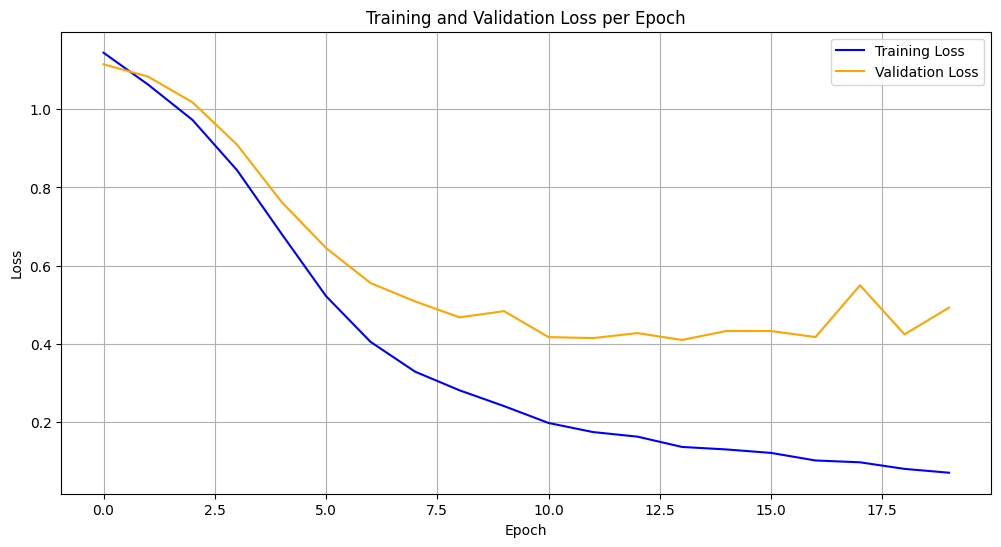

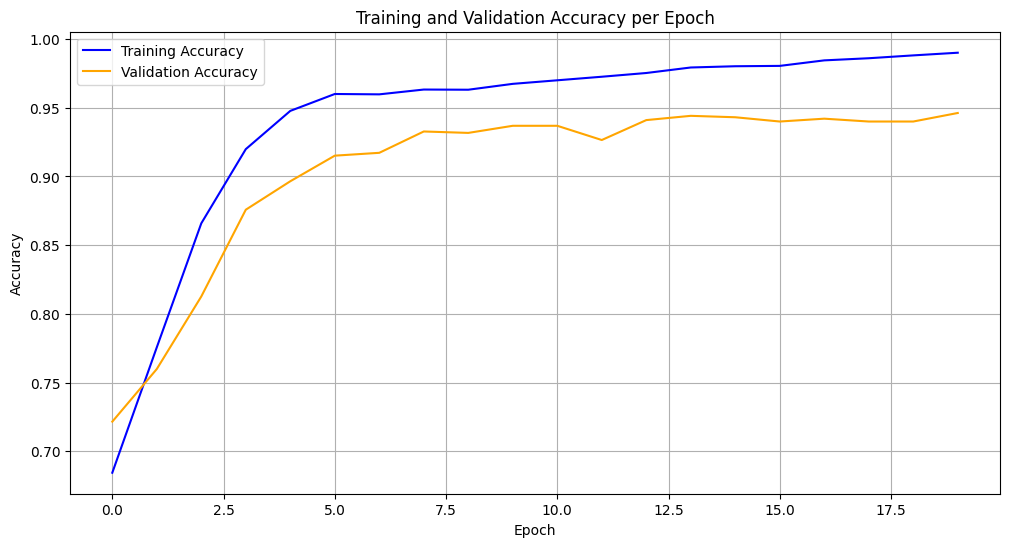

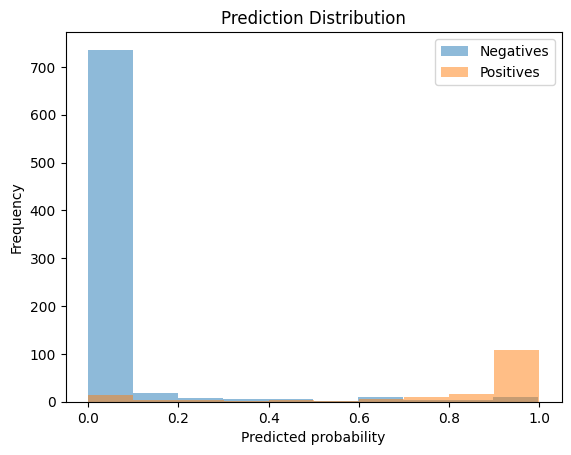

In [22]:
# ---------- BEST MODEL ----------
bs = 32
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=False, num_workers=0)
label, prob, _ = train_model(CNN1DLSTM, train_loader, val_loader, output_layers=32, kernel_size=3, dropout_rate=0.2, learning_rate=7.0e-05, batch_size=bs, num_epoch=20, threshold=0.5)
plt.hist(prob[label == 0], alpha=0.5, label='Negatives')
plt.hist(prob[label == 1], alpha=0.5, label='Positives')
plt.xlabel("Predicted probability")
plt.ylabel("Frequency")
plt.title("Prediction Distribution")
plt.legend()
plt.show()

Epoch 1/30, Train Loss: 1.1598, Val Loss: 1.1576, Train Acc: 0.8094, Val Acc: 0.8085, Train F1: 0.0564, Val F1: 0.0513, Train AUC: 0.50957202369713, Val AUC: 0.506875
Epoch 2/30, Train Loss: 1.1460, Val Loss: 1.1434, Train Acc: 0.8004, Val Acc: 0.7836, Train F1: 0.1239, Val F1: 0.1328, Train AUC: 0.5718331051737161, Val AUC: 0.5543524096385543
Epoch 3/30, Train Loss: 1.1237, Val Loss: 1.1304, Train Acc: 0.8211, Val Acc: 0.8344, Train F1: 0.2130, Val F1: 0.2157, Train AUC: 0.6623492966389728, Val AUC: 0.636453313253012
Epoch 4/30, Train Loss: 1.0801, Val Loss: 1.1017, Train Acc: 0.8278, Val Acc: 0.8282, Train F1: 0.3468, Val F1: 0.2906, Train AUC: 0.7470173243957703, Val AUC: 0.7001355421686748
Epoch 5/30, Train Loss: 0.9821, Val Loss: 0.9725, Train Acc: 0.8497, Val Acc: 0.8499, Train F1: 0.5132, Val F1: 0.4912, Train AUC: 0.8379100972432024, Val AUC: 0.8207906626506025
Epoch 6/30, Train Loss: 0.8249, Val Loss: 0.9263, Train Acc: 0.8722, Val Acc: 0.8768, Train F1: 0.6332, Val F1: 0.5609

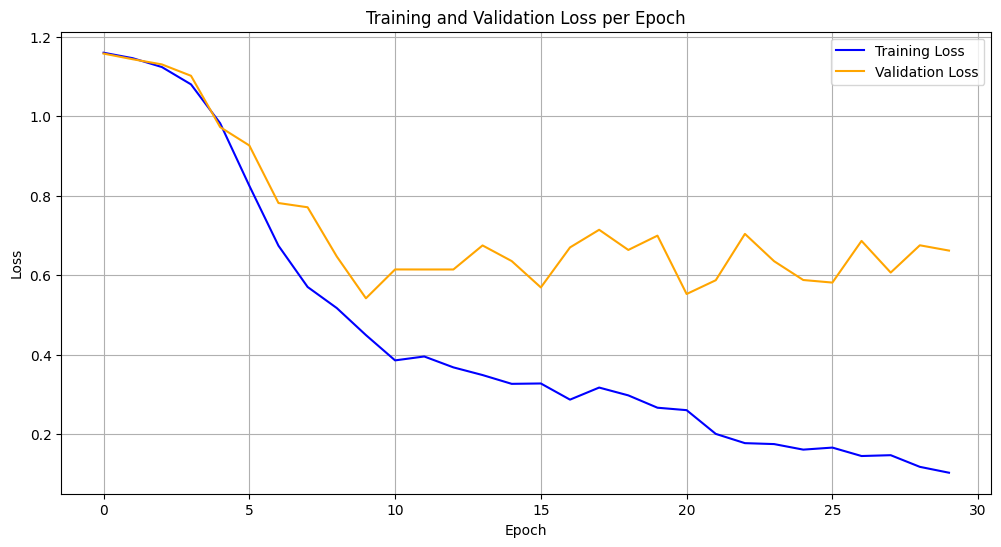

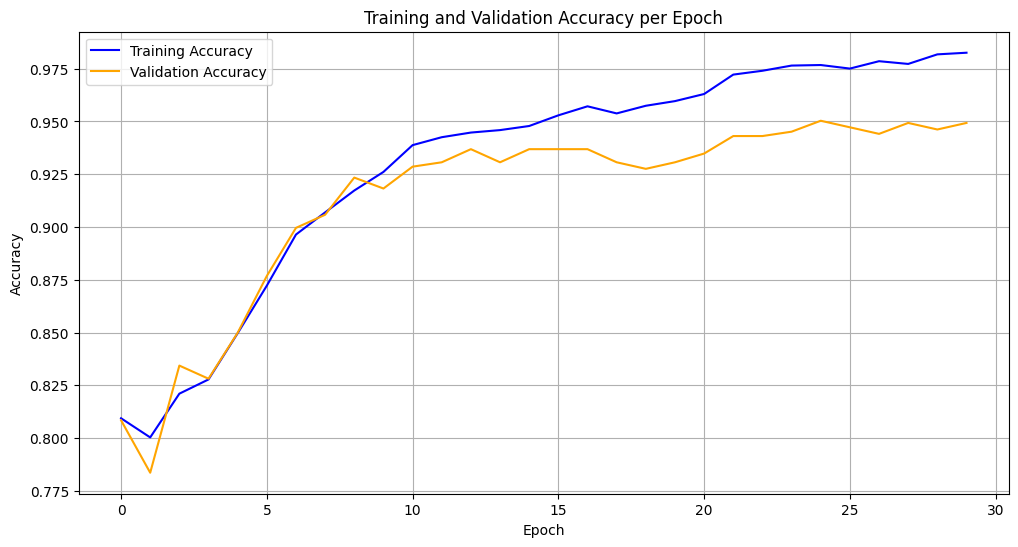

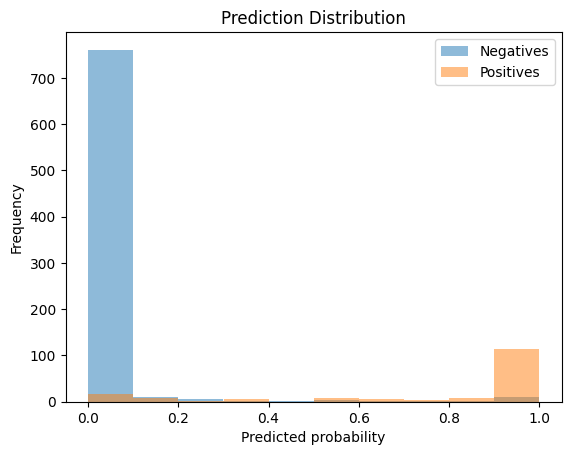

In [24]:
bs = 16
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=False, num_workers=0)
label, prob, _ = train_model(CNN2DLSTM, train_loader, val_loader, output_layers=32, kernel_size=3, dropout_rate=0.2, learning_rate=0.0002, batch_size=bs, num_epoch=30, threshold=0.5)
plt.hist(prob[label == 0], alpha=0.5, label='Negatives')
plt.hist(prob[label == 1], alpha=0.5, label='Positives')
plt.xlabel("Predicted probability")
plt.ylabel("Frequency")
plt.title("Prediction Distribution")
plt.legend()
plt.show()

Epoch 1/60, Train Loss: 1.1485, Val Loss: 1.1382, Train Acc: 0.5061, Val Acc: 0.2101, Train F1: 0.2594, Val F1: 0.2902, Train AUC: 0.5093264964123867, Val AUC: 0.5384939759036145
Epoch 2/60, Train Loss: 1.1474, Val Loss: 1.1368, Train Acc: 0.4212, Val Acc: 0.3737, Train F1: 0.2799, Val F1: 0.2891, Train AUC: 0.5273573805702416, Val AUC: 0.5258810240963856
Epoch 3/60, Train Loss: 1.1437, Val Loss: 1.1329, Train Acc: 0.5246, Val Acc: 0.6253, Train F1: 0.2774, Val F1: 0.2760, Train AUC: 0.5412681740936556, Val AUC: 0.5455120481927711
Epoch 4/60, Train Loss: 1.1383, Val Loss: 1.1310, Train Acc: 0.5177, Val Acc: 0.3789, Train F1: 0.2962, Val F1: 0.3182, Train AUC: 0.5649447696374622, Val AUC: 0.568019578313253
Epoch 5/60, Train Loss: 1.1285, Val Loss: 1.1119, Train Acc: 0.5682, Val Acc: 0.6346, Train F1: 0.3220, Val F1: 0.3225, Train AUC: 0.5973124763972809, Val AUC: 0.6040135542168675
Epoch 6/60, Train Loss: 1.1188, Val Loss: 1.1139, Train Acc: 0.6005, Val Acc: 0.7402, Train F1: 0.3241, Va

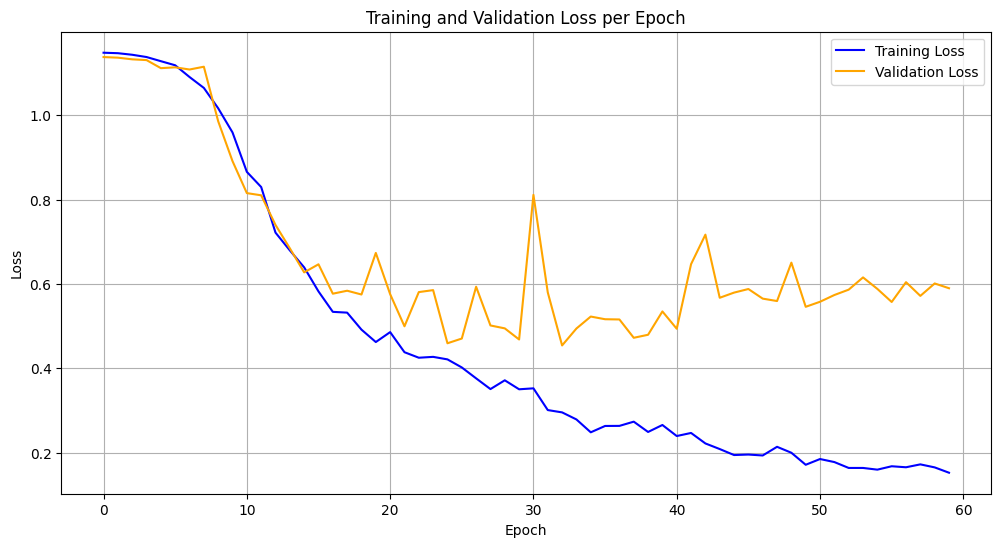

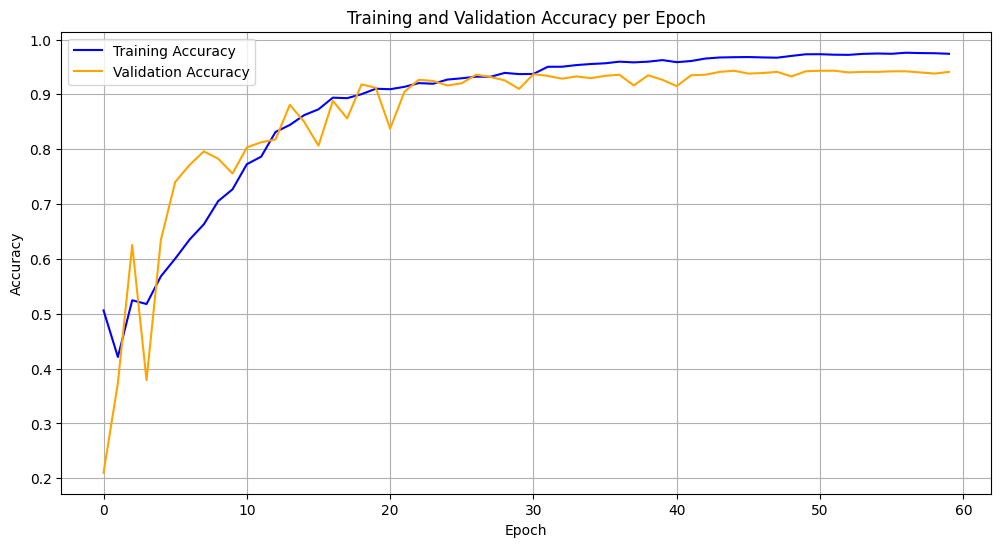

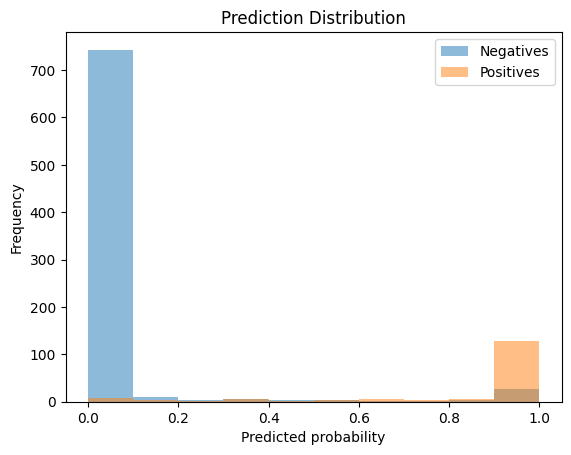

In [27]:
bs = 32
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=False, num_workers=0)
label, prob, _ = train_model(CNN2DBLSTM, train_loader, val_loader, output_layers=24, kernel_size=3, dropout_rate=0.5, learning_rate=0.0003, batch_size=bs, num_epoch=60, threshold=0.5)
plt.hist(prob[label == 0], alpha=0.5, label='Negatives')
plt.hist(prob[label == 1], alpha=0.5, label='Positives')
plt.xlabel("Predicted probability")
plt.ylabel("Frequency")
plt.title("Prediction Distribution")
plt.legend()
plt.show()

Epoch 1/40, Train Loss: 1.1489, Val Loss: 1.1368, Train Acc: 0.4876, Val Acc: 0.4379, Train F1: 0.2607, Val F1: 0.3012, Train AUC: 0.5092956358572508, Val AUC: 0.5352371987951806
Epoch 2/40, Train Loss: 1.1440, Val Loss: 1.1379, Train Acc: 0.6530, Val Acc: 0.7340, Train F1: 0.2485, Val F1: 0.1518, Train AUC: 0.534432885668429, Val AUC: 0.5313253012048194
Epoch 3/40, Train Loss: 1.1455, Val Loss: 1.1037, Train Acc: 0.5746, Val Acc: 0.5704, Train F1: 0.2835, Val F1: 0.3546, Train AUC: 0.5496558723564954, Val AUC: 0.6485993975903614
Epoch 4/40, Train Loss: 1.0841, Val Loss: 1.0225, Train Acc: 0.6643, Val Acc: 0.6739, Train F1: 0.3634, Val F1: 0.4112, Train AUC: 0.6566095284176736, Val AUC: 0.7296460843373493
Epoch 5/40, Train Loss: 1.0138, Val Loss: 1.0724, Train Acc: 0.7285, Val Acc: 0.8333, Train F1: 0.4244, Val F1: 0.4015, Train AUC: 0.7252756797583082, Val AUC: 0.750203313253012
Epoch 6/40, Train Loss: 0.9599, Val Loss: 0.9202, Train Acc: 0.7642, Val Acc: 0.6936, Train F1: 0.4711, Val

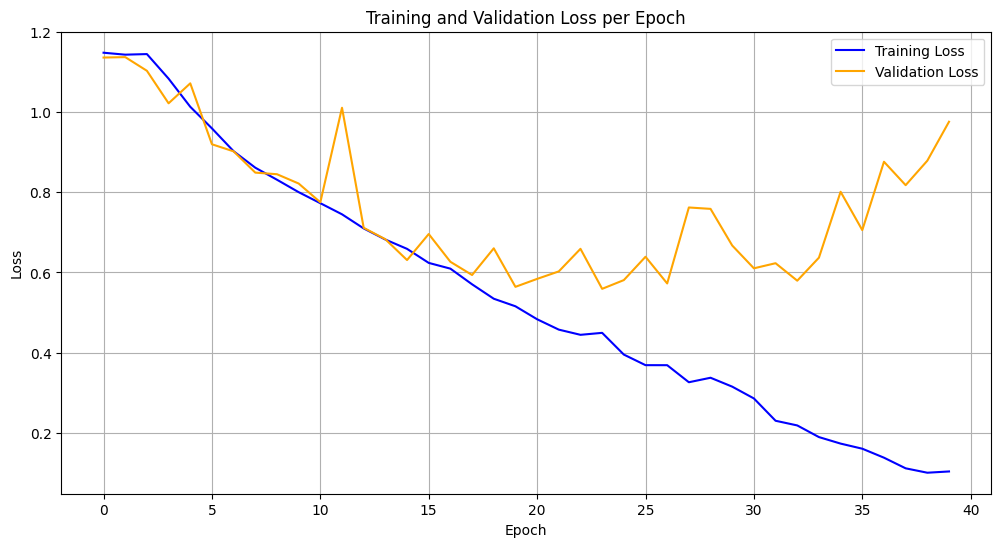

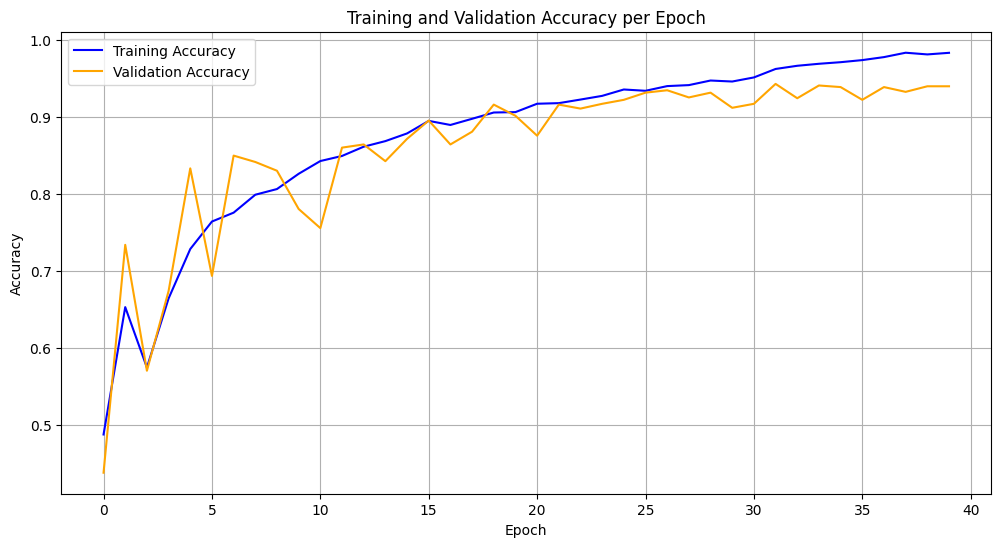

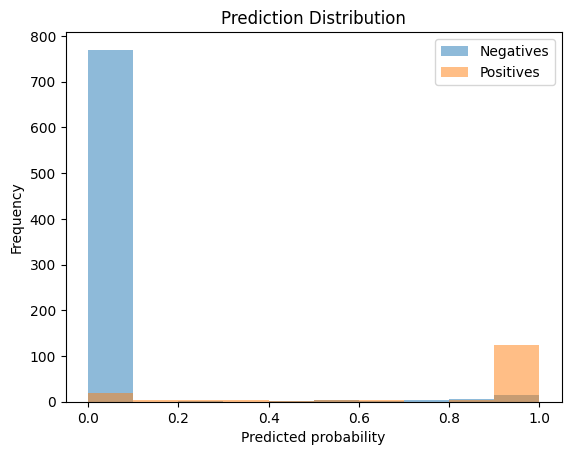

In [28]:
bs = 32
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=False, num_workers=0)
label, prob, _ = train_model(CNN1DBLSTM, train_loader, val_loader, output_layers=16, kernel_size=3, dropout_rate=0.2, learning_rate=0.003, batch_size=bs, num_epoch=40, threshold=0.5)
plt.hist(prob[label == 0], alpha=0.5, label='Negatives')
plt.hist(prob[label == 1], alpha=0.5, label='Positives')
plt.xlabel("Predicted probability")
plt.ylabel("Frequency")
plt.title("Prediction Distribution")
plt.legend()
plt.show()

### Hyperparameter Tuning

In [ ]:
search = {
    'model': [CNN2DLSTM_v3, CNN2DLSTM_v5, CNN2DBLSTM, CNN2DLSTM, CNN1DLSTM, CNN1DBLSTM],
    'output_layers': [16, 24, 32],
    'kernel_size': [3],
    'dropout_rate': [0.2, 0.5, 0.7],
    'learning_rate': list(np.logspace(np.log10(1e-5), np.log10(5e-2), num=200)),
    'batch_size': [8, 16, 32, 64],
    'num_epoch' : [20, 30, 40, 50, 60],
    'threshold': [0.2, 0.4, 0.5, 0.6, 0.7]
}

In [ ]:
def random_search(train_dataset, val_dataset, param, num_trials):
    random.seed(40)
    torch.manual_seed(40)
    
    top_models = []
    print("_______START_______")

    for trial in range(num_trials):
        params = {k: random.sample(v, 1)[0] for k, v in param.items()}
        
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        model_class = params['model']
        bs = params['batch_size']
        print(model_class)
        train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=0)
        val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=False, num_workers=0)

        true, prob, preds = train_model(
            model_class,
            train_loader,
            val_loader,
            output_layers=params['output_layers'],
            kernel_size=3,
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate'],
            batch_size=bs,
            num_epoch=params['num_epoch'],
            threshold=params['threshold']
        )
        
        f1 = f1_score(true, preds)
        auroc = roc_auc_score(true, prob)
        accuracy = accuracy_score(true, preds)
        score = 0.33 * auroc + 0.33 * f1 + 0.33 * accuracy

        top_models.append((params, f1, auroc, accuracy, score))

        print(f"Trial {trial+1}/{num_trials}: F1={f1:.4f}, AUROC={auroc:.4f}, Acc={accuracy:.4f}, Score={score:.4f}, LR={params['learning_rate']}, Model={model_class}")

    top_models.sort(key=lambda x: x[4], reverse=True)
    print("_______END_______")
    return top_models

In [ ]:
top_models = random_search(train_dataset, val_dataset, search, 25) 
print("________Top Models_________")
for m in top_models:
    print(m)